In [10]:
from __future__ import print_function, division
import os
import glob
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import tensorflow as tf
from tensorflow.keras import Model
import tensorflow.keras.layers as layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, ReLU, Activation, Dropout
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses



# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion() 

In [ ]:
class AffectnetDataset(Dataset):
    """Affectnet Dataset"""

    def __init__(self, annotation_dir, image_dir, transform=None):
        """
        Args:
            annotation_dir (string): Path to annotation directory.
            image_dir (string): Path to images directory.
        """
        self.exp = pd.DataFrame(np.array([[path[124:].split("_")[0], np.load(path).item()] for path in glob.glob(annotation_dir + "_exp.npy")]))
        self.aro = pd.DataFrame(np.array([np.load(path).item() for path in glob.glob(annotation_dir + "_aro.npy")]))
        self.val = pd.DataFrame(np.array([np.load(path).item() for path in glob.glob(annotation_dir + "_val.npy")]))
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.exp)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir, self.exp.iloc[idx, 0] + ".jpg")
        image = io.imread(img_name)

        exp = self.exp.iloc[idx, 1]
        aro = self.aro.iloc[idx, 0]
        val = self.val.iloc[idx, 0]
        sample = {'image': image, 'exp': exp, 'aro': aro, 'val': val}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
train_set = AffectnetDataset(annotation_dir='/media/rifah/ACV/Assignment2/train_set/annotations/*',
                                    image_dir='/media/rifah/ACV/Assignment2/train_set/images/')

0 (224, 224, 3) 1 -0.0555556 0.785714


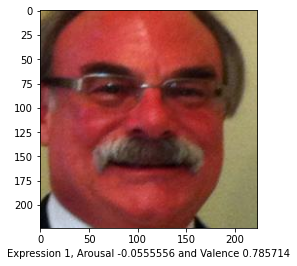

1 (224, 224, 3) 1 -0.137627 0.784476


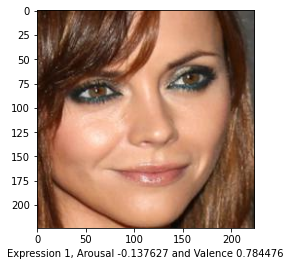

2 (224, 224, 3) 1 0.0919473 0.774293


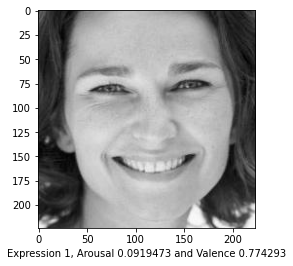

3 (224, 224, 3) 0 0.114565 0.0896593


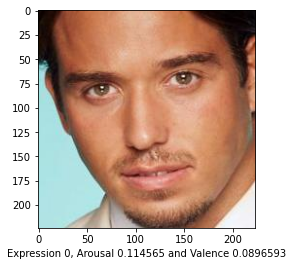

In [ ]:
for i in range(len(train_set)):
    sample = train_set[i]

    print(i, sample['image'].shape, sample['exp'], sample['aro'], sample['val'])

    plt.imshow(sample['image'])
    plt.xlabel("Expression {}, Arousal {} and Valence {}".format(sample['exp'], sample['aro'], sample['val']))
    plt.show()

    if i == 3:
        plt.show()
        break

In [ ]:
test_set = AffectnetDataset(annotation_dir='/media/rifah/ACV/Assignment2/train_set/annotations/*',
                                    image_dir='/media/rifah/ACV/Assignment2/test_sets/images/')

0 (224, 224, 3) 6 -0.0776398 -0.176846


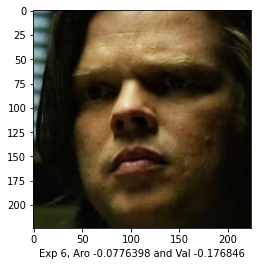

1 (224, 224, 3) 0 0.00483933 -0.135501


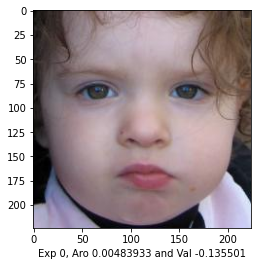

2 (224, 224, 3) 0 0.857748 -0.11451


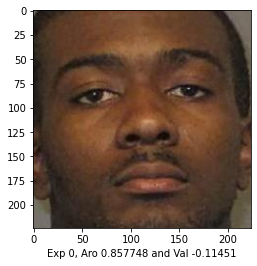

3 (224, 224, 3) 4 0.484127 -0.642857


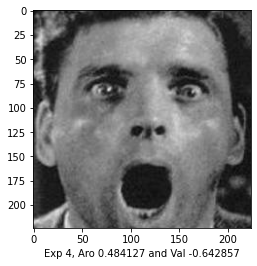

In [ ]:
for i in range(len(test_set)):
    sample = test_set[i]

    print(i, sample['image'].shape, sample['exp'], sample['aro'], sample['val'])

    plt.imshow(sample['image'])
    plt.xlabel("Exp {}, Aro {} and Val {}".format(sample['exp'], sample['aro'], sample['val']))
    plt.show()

    if i == 3:
        plt.show()
        break

In [ ]:
print("Train Data Size: {} and Test Data Size: {}".format(len(train_set), len(test_set)))

Train Data Size: 287651 and Test Data Size: 3999


In [ ]:
train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True)

Shape of Image: (128, 224, 224, 3), Label: (128,), Arousal: (128,), Valence: (128,).


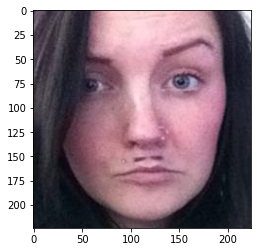

Label: 2


In [ ]:
# Display image and label.
train_iterator = next(iter(train_dataloader))
train_features = np.stack(train_iterator['image'], axis=0)
train_labels = np.array(train_iterator['exp']).astype("int")
train_arousal = np.array(train_iterator['aro']).astype("float")
train_valence = np.array(train_iterator['val']).astype("float")

print("Shape of Image: {}, Label: {}, Arousal: {}, Valence: {}.".format(np.shape(train_features), 
                                                                        np.shape(train_labels),
                                                                       np.shape(train_arousal),
                                                                       np.shape(train_valence)))

img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap="gray")
plt.show()

print(f"Label: {label}")

In [12]:
# ------------------------------- VGG 16--------------------------------
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_56 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_58 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

In [ ]:
for i, train_iterator in enumerate(train_dataloader):
    if i % 100 == 0:
        print("---------------------- Training ---------------------".format(i + 1))
    
    train_features = np.stack(train_iterator['image'], axis=0)
    train_labels = np.array(train_iterator['exp']).astype("int")
    
    model.fit(train_features, train_labels, validation_split=0.2)

In [ ]:
test_dataloader = DataLoader(test_set, batch_size=3999, shuffle=True)

In [ ]:
test_iterator = next(iter(test_dataloader))
test_features = np.stack(test_iterator['image'], axis=0)
test_labels = np.array(test_iterator['exp']).astype("int")

predictions = model.predict(test_features)
print(predictions)
print(np.shape(predictions))
model.evaluate(train_features, train_labels)

In [ ]:
# Display image and label.
test_iterator = next(iter(test_dataloader))
test_features = np.stack(test_iterator['image'], axis=0)
test_labels = np.array(test_iterator['exp']).astype("int")
test_arousal = np.array(test_iterator['aro']).astype("float")
test_valence = np.array(test_iterator['val']).astype("float")

print("Shape of Image: {}, Label: {}, Arousal: {}, Valence: {}.".format(np.shape(test_features), 
                                                                        np.shape(test_labels),
                                                                       np.shape(test_arousal),
                                                                       np.shape(test_valence)))

img = test_features[0].squeeze()
label = test_labels[0]
predicted_label = np.argmax(predictions[0])

plt.imshow(img, cmap="gray")
plt.show()

print(f"Label: {label} and Predicted label: {predicted_label}")

In [ ]:
# ------------------------------- ResNet 50 -------------------------------
def bottleneck_block(n_filters, x):
    """ Create a Bottleneck Residual Block of Convolutions
    n_filters: number of filters
    x : input into the block
    """
    shortcut = x
    x = layers.Conv2D(n_filters, (1, 1), strides=(1, 1))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(n_filters, (3, 3), strides=(1, 1), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(n_filters * 4, (1, 1), strides=(1, 1))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.add([shortcut, x])
    x = layers.ReLU()(x)
    
    return x

def conv_block(n_filters, x, strides=(2,2)):
    """ Create Block of Convolutions with feature pooling
    Increase the number of filters by 4X
    n_filters: number of filters
    x : input into the block
    """
    # construct the identity link
    # increase filters by 4X to match shape when added to output of block
    shortcut = layers.Conv2D(4 * n_filters, (1, 1), strides=strides)(x)
    shortcut = layers.BatchNormalization()(shortcut)
    
    # construct the 1x1, 3x3, 1x1 convolution block
    
    # feature pooling when strides=(2, 2)
    x = layers.Conv2D(n_filters, (1, 1), strides=strides)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # increase the number of filters by 4X
    x = layers.Conv2D(4 * n_filters, (1, 1), strides=(1, 1))(x)
    x = layers.BatchNormalization()(x)
    
    # add the identity link to the output of the convolution block
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

# The input tensor
inputs = layers.Input(shape=(224, 224, 3))

# First Convolutional layer, where pooled feature maps will be reduced by 75%
x = layers.ZeroPadding2D(padding=(3, 3))(inputs)
x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='valid')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.ZeroPadding2D(padding=(1, 1))(x)
x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)

x = conv_block(64, x, strides=(1,1))

# First Residual Block Group of 64 filters
for _ in range(2):
    x = bottleneck_block(64, x)
    

# Double the size of filters and reduce feature maps by 75% (strides=2, 2) to fit the next Residual Group
x = conv_block(128, x)

# Second Residual Block Group of 128 filters
for _ in range(3):
    x = bottleneck_block(128, x)

    
# Double the size of filters and reduce feature maps by 75% (strides=2, 2) to fit the next Residual Group
x = conv_block(256, x)

# Third Residual Block Group of 256 filters
for _ in range(5):
    x = bottleneck_block(256, x)

# Double the size of filters and reduce feature maps by 75% (strides=2, 2) to fit the next Residual Group
x = conv_block(512, x)

# Fourth Residual Block Group of 512 filters
for _ in range(2):
    x = bottleneck_block(512, x)

# Now Pool at the end of all the convolutional residual blocks
x = layers.GlobalAveragePooling2D()(x)

# Final Dense Outputting Layer for 1000 outputs
outputs = layers.Dense(8, activation='softmax')(x)

resnet50_model = Model(inputs, outputs)

In [ ]:
resnet50_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_54 (Conv2D)             (None, 112, 112, 64  9472        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [ ]:
# Use the Categorical Cross Entropy loss function for a Multi-Class Classifier.
resnet50_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
for i, train_iterator in enumerate(train_dataloader):
    if i % 100 == 0:
        print("---------------------- Training --------------------".format(i + 1))
    
    train_features = np.stack(train_iterator['image'], axis=0)
    train_labels = np.array(train_iterator['exp']).astype("int")
    
    resnet50_model.fit(train_features, train_labels, validation_split=0.2)